<a href="https://colab.research.google.com/github/animesharma3/Who-the-fcuk-Subscribed---Using-Logistic-Regression/blob/master/Who_the_fcuk_Subscribed%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import Useful Modules

# Basic Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modules for handling imbalanced dataset
from imblearn.over_sampling import SMOTE # SMOTE - Synthetic Minority Oversampling Technique

# feature Selection module - RFE(Recursive Feature Elimination)
from sklearn.feature_selection import RFE

# Modules for spliting training and testing data
from sklearn.model_selection import train_test_split

# Modules for implementing the model
import statsmodels.api as sm

# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

# Accuracy testing metrics
from sklearn.metrics import confusion_matrix, classification_report

In [13]:
# Importing the dataset

dataset_url = 'https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv'
data = pd.read_csv(dataset_url, sep=',')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [0]:
# Droping NaN values if any
data = data.dropna()

## **Data Exploration**

In [15]:
data.shape

(41188, 21)

In [16]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [0]:
# Separating Numerical and Categorical Variables

# numeric - age, duration, campaign, pdays, previous, emp_var_rate, cons_price_idx, euribor3m, nr_employed
# categorical - job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome, y

In [18]:
categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
for var in categorical_vars:
    print(var)
    print(data[var].unique())
    print('---------------------------------------------------------------------------')

job
['blue-collar' 'technician' 'management' 'services' 'retired' 'admin.'
 'housemaid' 'unemployed' 'entrepreneur' 'self-employed' 'unknown'
 'student']
---------------------------------------------------------------------------
marital
['married' 'single' 'divorced' 'unknown']
---------------------------------------------------------------------------
education
['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']
---------------------------------------------------------------------------
default
['unknown' 'no' 'yes']
---------------------------------------------------------------------------
housing
['yes' 'no' 'unknown']
---------------------------------------------------------------------------
loan
['no' 'yes' 'unknown']
---------------------------------------------------------------------------
contact
['cellular' 'telephone']
---------------------------------------------------------------------------
month
['aug' 'no

In [19]:
# Looks like education has lot of repetitive categories like basic.4y, basic.6y, basic.9y
print('Before')
print(data.education.unique())
print('---------------------------------------------------------------------')
to_replace = ['basic.4y', 'basic.6y', 'basic.9y']
data.education = data.education.replace(to_replace=to_replace, value='basic')
print('After')
data.education.unique()

Before
['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']
---------------------------------------------------------------------
After


array(['basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

In [20]:
# Entire dataset is classified into 2 classes 0 and 1 in 'y' column
data.y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

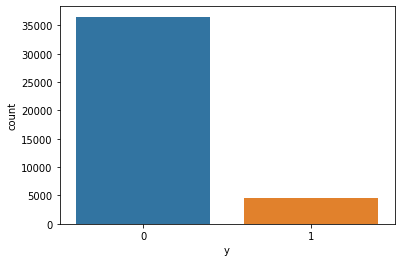

In [22]:
sns.countplot(data.y) # Looks like dataset is highly imbalanced

In [24]:
# Imbalanced dataset!
count_0 = len(data[data['y'] == 0])
count_1 = len(data[data['y'] == 1])
percent_0 = count_0 / (count_0 + count_1) * 100
percent_1 = count_1 / (count_0 + count_1) * 100
print(percent_0, percent_1) # => highly imbalanced

88.73458288821988 11.265417111780131


## **More Data Exploration**

In [27]:
data.groupby('y').mean()
# avg age of people who subscribed is more than those who didn't subscribed
# avg pdays(no. of days before which the client is last called) is understandably less for those who subscribed

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


In [28]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


In [29]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [30]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [36]:
print(pd.crosstab(data.marital, data.y))
print('--------------------------')
print(data.marital.value_counts())

y             0     1
marital              
divorced   4136   476
married   22396  2532
single     9948  1620
unknown      68    12
--------------------------
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


In [40]:
table = pd.crosstab(data.marital, data.y)
table = table.div(table.sum(axis=1).astype(float), axis=0)
table

y,0,1
marital,,
divorced,0.896791,0.103209
married,0.898427,0.101573
single,0.859959,0.140041
unknown,0.850000,0.150000


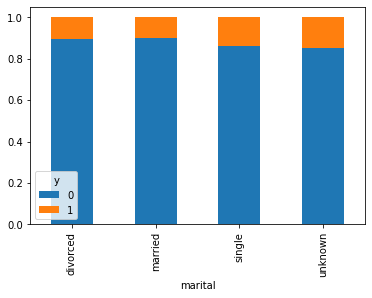

In [41]:
table.plot(kind="bar", stacked=True)

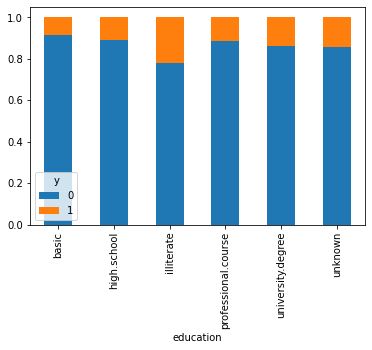

In [42]:
table = pd.crosstab(data.education, data.y)
table.div(table.sum(axis=1), axis=0).plot(kind="bar", stacked=True)

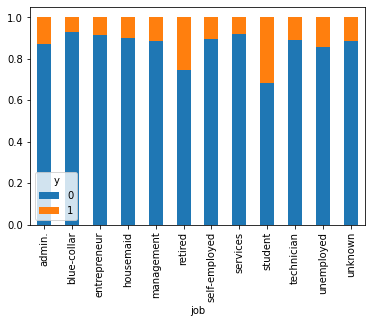

In [43]:
table = pd.crosstab(data.job, data.y)
table.div(table.sum(axis=1), axis=0).plot(kind="bar", stacked=True)

## **One Hot Encoding of all the categorical Variables**

In [44]:
for var in categorical_vars:
    categories = pd.get_dummies(data[var], prefix=var)
    data = pd.concat([data, categories], axis=1)
data.columns.values

array(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'education_basic',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown',
       'default_yes', 'housing_no', 'housing_unknown', 'housing_yes',
       'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec',
 

In [0]:
# Removing all the numerical variables and lead categorical var and all the One Hot Encoded categories
data_vars = data.columns.values.tolist()
to_keep = [col for col in data_vars if col not in categorical_vars]
data_final = data[to_keep]

In [46]:
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

## **Handling Imbalanced Dataset**

In [0]:
X = data_final.iloc[:, data_final.columns != 'y']
Y = data_final.iloc[:, data_final.columns == 'y']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

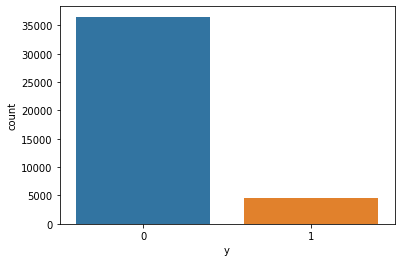

In [52]:
sns.countplot(Y.y) # Imbalanced dataset

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


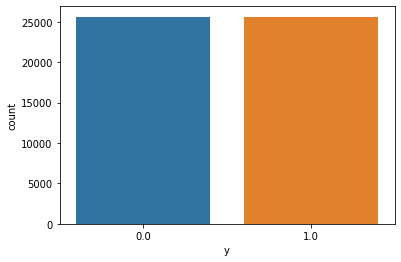

In [56]:
# Oversampling our data using SMOTE 
os = SMOTE(random_state=42)
os_data_X, os_data_Y = os.fit_sample(X_train, Y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=X_train.columns)
os_data_Y = pd.DataFrame(data=os_data_Y, columns=['y'])
sns.countplot(pd.concat([os_data_X, os_data_Y]).y)

## **Feature Selection - Recursive Feature Elimination**

In [0]:
data_final_vars = data_final.columns.values.tolist()
Y = ['y']
X = [i for i in data_final_vars if i not in Y]

In [65]:
logit = LogisticRegression()
rfe = RFE(logit, n_features_to_select=20)
rfe = rfe.fit(os_data_X, os_data_Y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[False False False False  True  True False False False False False False
 False False False  True False False  True False False False False False
 False False  True  True False False False False  True False False False
 False False  True False False False  True False False  True  True  True
  True  True  True  True  True False  True False False False  True False
  True]
[32 31  7 36  1  1 20 34 29 22 28  6 25 40 27  1 24  4  1 21 30 35 17 26
  5 39  1  1 38  2 19 16  1  3 42 33 18 11  1 10  9  8  1 23 12  1  1  1
  1  1  1  1  1 41  1 14 15 37  1 13  1]


In [66]:
# Accumulating all the features selected by RFE
cols = list()
for key, value in zip(rfe.support_, data_final_vars):
    if key == True:
        cols.append(value)
cols

['previous',
 'emp_var_rate',
 'job_management',
 'job_services',
 'marital_unknown',
 'education_basic',
 'education_unknown',
 'housing_yes',
 'contact_cellular',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'day_of_week_fri',
 'day_of_week_wed',
 'poutcome_nonexistent']

## **Implementing the model**

In [70]:
X = os_data_X[cols]
Y = os_data_Y['y']
logit_model = sm.Logit(Y, X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.560445
         Iterations 6
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.191     
Dependent Variable:   y                 AIC:               57467.7008
Date:                 2020-03-19 10:38  BIC:               57644.5839
No. Observations:     51234             Log-Likelihood:    -28714.   
Df Model:             19                LL-Null:           -35513.   
Df Residuals:         51214             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       6.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
previous              0.4761   0.0286  16.6713 0.0000  0.4201  0.5321
emp_var_rate    

In [71]:
result.pvalues

previous                 2.117940e-62
emp_var_rate             0.000000e+00
job_management           8.440327e-02
job_services             2.469074e-10
marital_unknown          6.752448e-01
education_basic          2.262865e-20
education_unknown        4.568892e-01
housing_yes              2.655068e-06
contact_cellular         9.451136e-01
month_aug                8.975965e-12
month_dec                1.744828e-01
month_jul                9.060156e-03
month_jun                2.089199e-06
month_mar                1.386245e-38
month_may               2.907672e-210
month_nov                4.547916e-73
month_oct                4.596852e-14
day_of_week_fri          6.108718e-01
day_of_week_wed          2.130083e-08
poutcome_nonexistent     1.821333e-07
dtype: float64

In [73]:
# Removing Columns with p-values more than 0.005
p_values = pd.DataFrame(
    {
        'col_name': result.pvalues.index,
        'pvalues': result.pvalues.values
    }
)
cols = p_values[p_values.pvalues < 0.005]['col_name']
cols

0                 previous
1             emp_var_rate
3             job_services
5          education_basic
7              housing_yes
9                month_aug
12               month_jun
13               month_mar
14               month_may
15               month_nov
16               month_oct
18         day_of_week_wed
19    poutcome_nonexistent
Name: col_name, dtype: object

In [74]:
X = os_data_X[cols]
Y = os_data_Y['y']
logit_model = sm.Logit(Y, X)
result = logit_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.560573
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit             Pseudo R-squared:  0.191     
Dependent Variable:   y                 AIC:               57466.7739
Date:                 2020-03-19 10:42  BIC:               57581.7480
No. Observations:     51234             Log-Likelihood:    -28720.   
Df Model:             12                LL-Null:           -35513.   
Df Residuals:         51221             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       6.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
previous              0.5156   0.0229  22.5226 0.0000  0.4708  0.5605
emp_var_rate         -0.4971   0.0071 -70.0897 0.0000 -0.5110 -0.4832
job_services         -0.2373   0.0392  -6.0480 0.0000 -0.3142 -0.1604
education_basic      -0.2192   0.0246  -8.9165 0.0000 -0.2674 -0.1710
housing_yes          -0.0982   0.0218  -4.5133 0.0000 -0.1409 -0.0556
month_aug            -0.3840   0.0345 -11.1283 0.0000 -0.4516 -0.3163
month_jun            -0.2790   0.0354  -7.8862 0.0000 -0.3483 -0.2097
month_mar             1.1737   0.0927  12.6596 0.0000  0.9920  1.3554
month_may            -1.1734   0.0277 -42.3642 0.0000 -1.2277 -1.1191
month_nov            -0.8858   0.0377 -23.4722 0.0000 -0.9597 -0.8118
month_oct             0.5659   0.0801   7.0656 0.0000  0.4089  0.7229
day_of_week_wed       0.1579   0.0273   5.7947 0.0000  0.1045  0.2114
poutcome_nonexistent  0.2582   0.0240  10.7776 0.0000  0.2112  0.3051
=====================================================================

"""

## **Logistic Regression Model Fitting**

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
logit = LogisticRegression()
logit.fit(X_train, Y_train)
print("Logistic Regression Accuracy",logit.score(X_test, Y_test))

Logistic Regression Accuracy 0.7492681022705094


In [0]:
Y_pred = logit.predict(X_test)

In [78]:
confusion_matrix = confusion_matrix(Y_test, Y_pred)
confusion_matrix

array([[6603, 1103],
       [2751, 4914]])

In [80]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.71      0.86      0.77      7706
           1       0.82      0.64      0.72      7665

    accuracy                           0.75     15371
   macro avg       0.76      0.75      0.75     15371
weighted avg       0.76      0.75      0.75     15371

